<a href="https://colab.research.google.com/github/rafif22-sys/2025_VisiKomputer_TI-2A/blob/main/Jobsheet03_VisiKomputer_Praktikum2-Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# PRAKTIKUM D2
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rafifalifahrezi","key":"2a61ac21ae95fdad3fb63de39e3c8bd3"}'}

In [ ]:
import os, shutil
if os.path.exists("kaggle.json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
  os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
  !pip -q install kaggle
  print("Kaggle API siap digunakan.")
else:
  print("Kaggle.json belum ditemukan. Upload terlebih dahulu")

Kaggle API siap digunakan.


In [ ]:
!kaggle datasets download -d jangedoo/utkface-new -p/content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("Dataset UTKFace berhasil diekstrak")


Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
Dataset UTKFace berhasil diekstrak


Total Gambar ditemukan: 23708


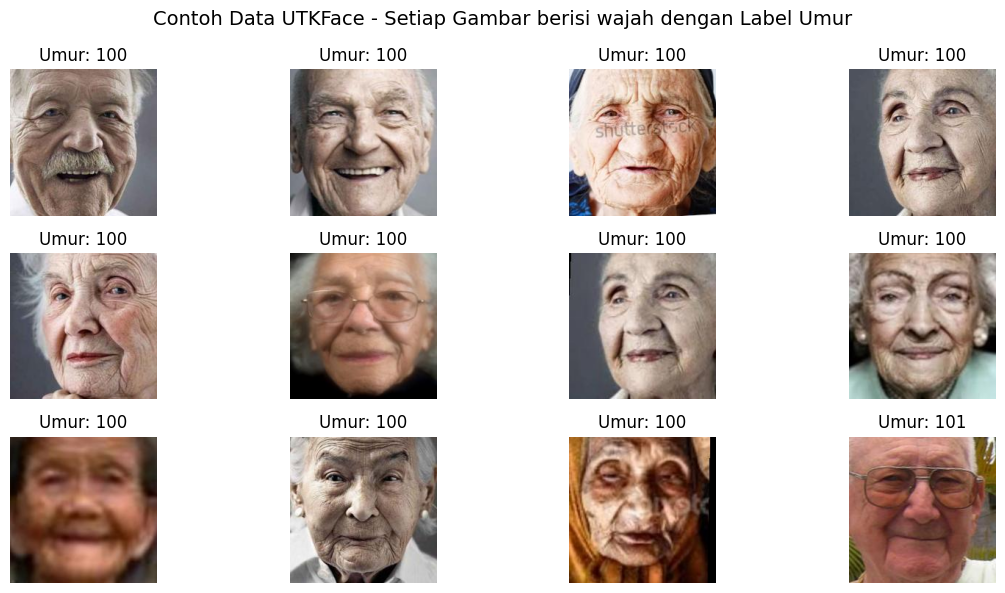

In [ ]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

files = glob.glob("/content/utk/UTKFace/*.jpg")
files =  sorted(files)

print(f"Total Gambar ditemukan: {len(files)}")

plt.figure(figsize=(12,6))
for i,f in enumerate(files[:12]):
  age = int(os.path.basename(f).split("_")[0])
  img = Image.open(f)
  plt.subplot(3,4,i + 1)
  plt.imshow(img)
  plt.title(f"Umur: {age}")
  plt.axis("off")
plt.suptitle("Contoh Data UTKFace - Setiap Gambar berisi wajah dengan Label Umur",fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
  return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(files, ages, test_size=0.2, random_state=42)

IMG_SIZE = 160
def load_img(fp, label):
  img = tf.io.read_file(fp)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
  return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files,y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files,y_test)).map(load_img).batch(64)
print("Dataset siap dilatih")

Dataset siap dilatih


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

print("Hardware:","GPU" if tf.config.list_physical_devices('GPU') else "CPU")

base_model = tf.keras.applications.MobileNetV2(
    include_top = False,
    input_shape = (IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)

base_model_trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),loss='mse',metrics=['mae'])
model.summary()

Hardware: GPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 2,387,969 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 147s 284ms/step - loss: 227.6633 - mae: 10.2488 - val_loss: 11124.4531 - val_mae: 104.3059 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 36s 120ms/step - loss: 69.2310 - mae: 6.0343 - val_loss: 6271.6504 - val_mae: 77.5221 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 37s 123ms/step - loss: 50.5539 - mae: 5.1841 - val_loss: 6512.7900 - val_mae: 78.6569 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - loss: 45.3013 - mae: 4.9281 - val_loss: 2018.3486 - val_mae: 42.6492 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 37s 126ms/step - loss: 39.5099 - mae: 4.6215 - val_loss: 1148.8479 - val_mae: 31.3129 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 37s 125ms/step - loss: 33.1137 - mae: 4.2720 - val_loss: 1017.3365 - val_mae: 29.4652 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 37s 123ms/step - loss: 29.0347 - mae: 4.0003 - val_loss

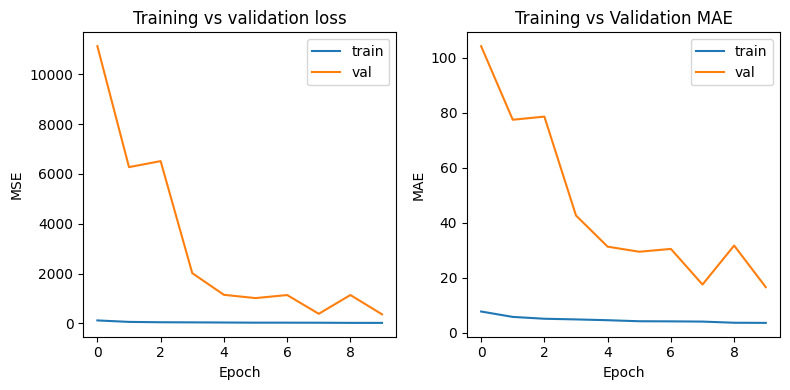

In [ ]:
#Langkah 7
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

history = model.fit(
    train_ds,
    validation_data = test_ds,
    epochs=10,
    callbacks = cb,
    verbose = 1
)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Training vs validation loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'],label='val')
plt.xlabel('Epoch');plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 116s 220ms/step - loss: 20.6622 - mae: 3.3553 - val_loss: 260.9708 - val_mae: 14.0773 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - loss: 13.6158 - mae: 2.7590 - val_loss: 167.0542 - val_mae: 10.7297 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - loss: 10.2075 - mae: 2.4004 - val_loss: 108.3844 - val_mae: 8.2295 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 37s 124ms/step - loss: 7.6106 - mae: 2.0680 - val_loss: 76.2389 - val_mae: 6.5693 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 38s 127ms/step - loss: 5.6087 - mae: 1.7547 - val_loss: 69.2398 - val_mae: 6.1499 - learning_rate: 1.0000e-04


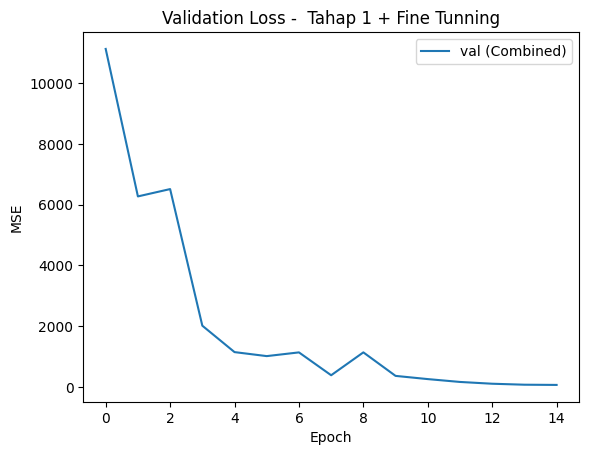

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
  layers.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),loss='mse',metrics=['mae'])

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

plt.plot(history.history['val_loss'] + history_ft.history['val_loss'],
         label='val (Combined)')
plt.title("Validation Loss -  Tahap 1 + Fine Tunning")
plt.xlabel("Epoch");plt.ylabel("MSE")
plt.legend();plt.show()

MAE = 6.15 Tahun
RMSE = 8.32 Tahun
R2 = 0.826


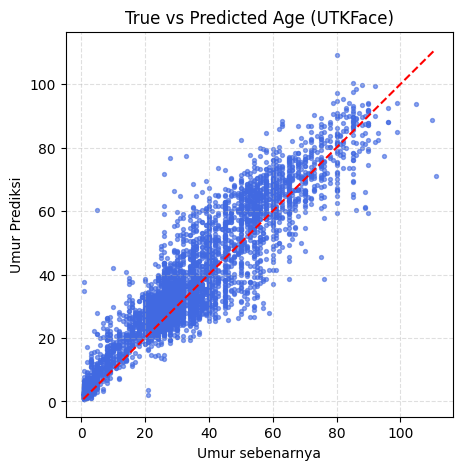

In [ ]:
#Langkah 9
from math import sqrt

y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred) ** 2))
r2 = r2_score(y_test, y_pred)

print(f"MAE = {mae:.2f} Tahun")
print(f"RMSE = {rmse:.2f} Tahun")
print(f"R2 = {r2:.3f}")

plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

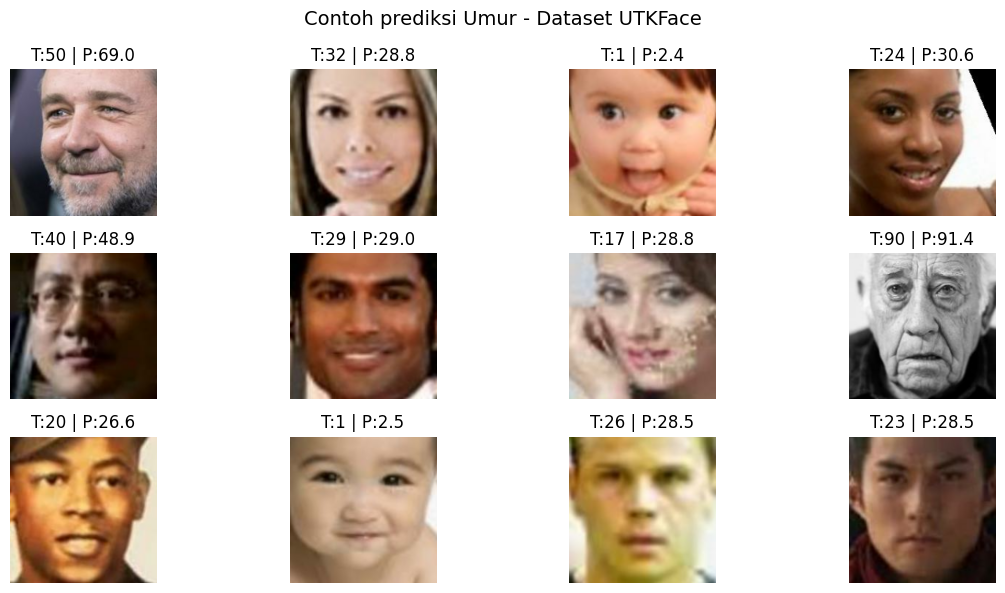

In [ ]:
import random
sample_paths = random.sample(test_files, 12)

plt.figure(figsize=(12,6))
for i, path in enumerate(sample_paths):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
  true_age = int(os.path.basename(path).split('_')[0])
  pred_age = model.predict(tf.expand_dims(img,0), verbose=0).ravel()[0]
  plt.subplot(3,4, i+1)
  plt.imshow(img.numpy())
  plt.title(f"T:{true_age} | P:{pred_age:.1f}")
  plt.axis("off")
plt.suptitle("Contoh prediksi Umur - Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()

Saving rafiflagipcc.jpg to rafiflagipcc.jpg

📸 File diunggah: rafiflagipcc.jpg
🧠 Perkiraan umur: 17.7 tahun


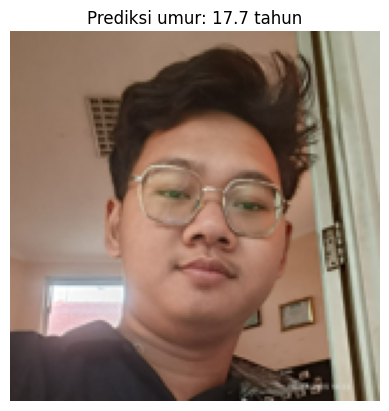

In [ ]:
# Penugasan
from google.colab import files
uploaded = files.upload()

import os
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

for fn in uploaded.keys():
    print(f"\n📸 File diunggah: {fn}")
    path = fn

    img = Image.open(path).convert('RGB')
    img = img.resize((IMG_SIZE, IMG_SIZE))

    img_array = np.array(img) / 255.0
    img_tensor = tf.expand_dims(img_array, 0)  # bentuk (1, IMG_SIZE, IMG_SIZE, 3)

    pred_age = model.predict(img_tensor, verbose=0).ravel()[0]
    print(f"🧠 Perkiraan umur: {pred_age:.1f} tahun")

    plt.imshow(img)
    plt.title(f"Prediksi umur: {pred_age:.1f} tahun")
    plt.axis("off")
    plt.show()
